In [ ]:
# GRU 구조 및 설명
# 현재 시점의 정보를 바탕으로 과거 정보를 얼마나 잊을지 또는 기억할지 등을 계산하고, 그 결과에 현재 정보를 추가해서 다음 시점으로 정보를 전달함
# reset gate, update gate, candidate(데이터선정), output(출력값 계산) 등으로 구성
# gate는 memory cell에 정보를 저장하고 다음 단계로 전달하는 역할 수행

# reset gate
# Rt = sigmoid(Ur x Xt + Wr x Ht-1 + br) 0~1 사이 값
# 계산값이 1에 가깝다면 과거 정보를 많이 활용, 0에 가깝다면 과거 정보를 많이 잃게 되는 원리
# reset gate는 과거의 정보를 얼마나 잊을지(또는 기억할지) 결정하는 게이트

# update gate
# Ut = sigmoid(Uu x Xt + Wu x Ht-1 + bu) 0~1 사이 값
# 'Ct = tanh(Uc x Xt + Wc x Ht-1 + bc)
# 과거와 현재의 정보가운데 어떤 정보를 더 많이 업데이트 할지를 결정하는 게이트
# GRU update gate는 LSTM input gate와 forget gate를 합쳐놓은 개념

# candidate(데이터선정)
# 'Ht = tanh(Uc x Xt + Wc x Ht-1 * Rt + bc)
# 데이터 선정단계는 다음 시점으로 전달해줄 데이터 Ht를 만들기 위해, 현재 시점의 데이터를 선정하는 단계

# output(출력값 계산)
# Ht = (1 - Ut) * Ht-1 + Ut * 'Ht
# 수식의 Ut 부분은 현재 시점의 데이터 중 얼마나 가져갈 것인지를 나타내며, 1-Ut 부분은 얼마나 잊을지를 나타냄

In [2]:
# LSTM을 이용한 삼성전자 주가 예측
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

# GPU 설정
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [3]:
# 삼성전자 주식 데이터 다운로드
!pip install finance-datareader

In [4]:
# 삼정전자 데이터 로드, 삼성전자(005930)
df = fdr.DataReader('005930', '2020-01-01', '2025-07-30')
# df.head(3)
df = df[ ['Open', 'High', 'Low', 'Volume', 'Close'] ]
df.head(10)

,Open,High,Low,Volume,Close
Date,,,,,
2020-01-02,55500,56000,55000,12993228,55200
2020-01-03,56000,56600,54900,15422255,55500
2020-01-06,54900,55600,54600,10278951,55500
2020-01-07,55700,56400,55600,10009778,55800
2020-01-08,56200,57400,55900,23501171,56800
2020-01-09,58400,58600,57400,24102579,58600
2020-01-10,58800,59700,58300,16000170,59500
2020-01-13,59600,60000,59100,11359139,60000
2020-01-14,60400,61000,59900,16906295,60000


In [5]:
# 하이퍼 파라미터
FEATURE_NUMS = 4        # 입력층으로 들어가는 데이터 개수 feature
SEQ_LENGTH = 5          # 정답을 만들기 위해 필요한 시점 개수 time step
HIDDEN_SIZE = 4         # RNN 계열 계층을 구성하는 hidden state 개수
NUM_LAYERS = 1          # RNN 계열 계층이 몇겹으로 쌓였는지 나타냄
LEARNING_RATE = 1e-3    # 학습율
BATCH_SIZE = 20         # 학습을 위한 배치사이즈 개수

# feature - 'Open', 'High', 'Low', 'Volume'
# label - 'Close'
# sequence(time step) - 5일치 데이터

In [6]:
# 데이터 스케일링 / 시퀀스 데이터 만들기
SPLIT = int(0.7 * len(df)) # train : test = 7 : 3

train_df = df[ :SPLIT]
test_df = df[SPLIT: ]

print(train_df.shape, test_df.shape)

(959, 5) (412, 5)


In [7]:
# 데이터 스케일링
scaler_x = MinMaxScaler() # feature scaling
train_df.iloc[ : , :-1] = scaler_x.fit_transform(train_df.iloc[ : , :-1])
test_df.iloc[ : , :-1] = scaler_x.fit_transform(test_df.iloc[ : , :-1])

# label scaling 별도로 하는 이유는 0~1 사이의 값을 원래의 값 50,000 등으로 변환하기 위함, inverse_transform() 함수 사용
scaler_y = MinMaxScaler() # label scaling
train_df.iloc[ : , -1] = scaler_y.fit_transform(train_df.iloc[ : , [-1]])
test_df.iloc[ : , -1] = scaler_y.fit_transform(test_df.iloc[ : , [-1]])

C:\Users\AI\AppData\Local\Temp\ipykernel_532\493695545.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.27044025 0.28092243 0.25786164 0.27463312 0.2851153  0.3312369
 0.33962264 0.35639413 0.37316562 0.35429769 0.34591195 0.40461216
 0.4067086  0.4067086  0.37526205 0.40251572 0.35220126 0.34591195
 0.33962264 0.31865828 0.27044025 0.30398323 0.36477987 0.36687631
 0.38784067 0.34800839 0.360587   0.37106918 0.38993711 0.3836478
 0.39832285 0.38155136 0.360587   0.37945493 0.33962264 0.31027254
 0.2851153  0.28092243 0.28721174 0.25995807 0.24528302 0.29559748
 0.2557652  0.31446541 0.29140461 0.25366876 0.23480084 0.24528302
 0.17610063 0.10167715 0.1572327  0.09014675 0.10796646 0.07966457
 0.03249476 0.         0.02620545 0.13312369 0.13417191 0.14675052
 0.0932914  0.11320755 0.10167715 0.0754717  0.10062893 0.10272537
 0.14779874 0.14675052 0.14989518 0.13312369 0.12683438 0.12997904
 0.14150943 0.17190

In [8]:
# 시퀀스 데이터 만들기
def MakeSeqNumpyData(data, seq_length):
    x_seq_list = []
    y_seq_list = []

    for i in range(len(data) - seq_length):
        x_seq_list.append(data[ i:i + seq_length, :-1]) # 5일치 학습데이터
        y_seq_list.append(data[ i + seq_length, [-1]]) # 6일째 정답데이터
    
    # numpy data
    x_seq_numpy = np.array(x_seq_list)
    y_seq_numpy = np.array(y_seq_list)

    return x_seq_numpy, y_seq_numpy

In [9]:
# 시퀀스 데이터 생성

# train
x_train_data, y_train_data = MakeSeqNumpyData(data=np.array(train_df), 
                                              seq_length=SEQ_LENGTH)
# test
x_test_data, y_test_data = MakeSeqNumpyData(data=np.array(test_df), 
                                              seq_length=SEQ_LENGTH)

print(x_train_data.shape, y_train_data.shape)
print(x_test_data.shape, y_test_data.shape)

(954, 5, 4) (954, 1)
(407, 5, 4) (407, 1)


In [10]:
# tensor data 생성

# train
x_train_tensor = torch.FloatTensor(x_train_data).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train_data).to(DEVICE)
# test
x_test_tensor = torch.FloatTensor(x_test_data).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test_data).to(DEVICE)

# TensorDataset 생성
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# DataLoader 생성
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [11]:
# model 구축
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.GRU(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # gru hiddem state 0으로 초기화
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)

        outputs, _ = self.lstm(x, h0)
        last_hs = outputs[ :, -1, :]
        prediction = self.fc(last_hs)

        return prediction

In [12]:
# model 객체, 손실함수, 최적화 함수 생성

# LSTMModel(4, 4, 1)
model = GRUModel(FEATURE_NUMS, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)

# loss function
loss_function = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
# Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        
        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()

    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산

    return train_avg_loss

In [14]:
# model 학습
train_loss_list = []

EPOCHS = 200

for epoch in range(EPOCHS):

    train_avg_loss = model_train(dataloader=train_loader,
                           model=model,
                           loss_function=loss_function,
                           optimizer=optimizer)
    
    train_loss_list.append(train_avg_loss)

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss)
    )

epoch :  01 train loss =  0.353028
epoch :  02 train loss =  0.145068
epoch :  03 train loss =  0.058903
epoch :  04 train loss =  0.046303
epoch :  05 train loss =  0.043568
epoch :  06 train loss =  0.041006
epoch :  07 train loss =  0.038598
epoch :  08 train loss =  0.036377
epoch :  09 train loss =  0.034324
epoch :  10 train loss =  0.032419
epoch :  11 train loss =  0.030642
epoch :  12 train loss =  0.028975
epoch :  13 train loss =  0.027402
epoch :  14 train loss =  0.025912
epoch :  15 train loss =  0.024493
epoch :  16 train loss =  0.023136
epoch :  17 train loss =  0.021834
epoch :  18 train loss =  0.020583
epoch :  19 train loss =  0.019376
epoch :  20 train loss =  0.018211
epoch :  21 train loss =  0.017087
epoch :  22 train loss =  0.016002
epoch :  23 train loss =  0.014955
epoch :  24 train loss =  0.013948
epoch :  25 train loss =  0.012979
epoch :  26 train loss =  0.012051
epoch :  27 train loss =  0.011166
epoch :  28 train loss =  0.010323
epoch :  29 train lo

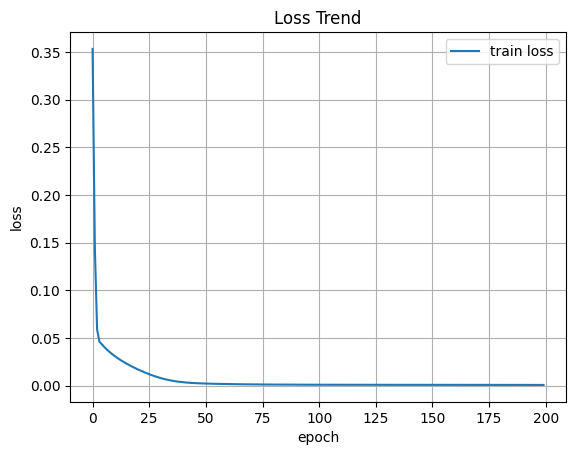

In [15]:
# 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.grid()
plt.legend(loc='best')
plt.show()

In [16]:
# 삼성전자 주가 예측

test_pred_tensor = model(x_test_tensor)

test_pred_numpy = test_pred_tensor.cpu().detach().numpy()

pred_inverse = scaler_y.inverse_transform(test_pred_numpy)

y_test_numpy = y_test_tensor.cpu().detach().numpy()

y_test_inverse = scaler_y.inverse_transform(y_test_numpy)


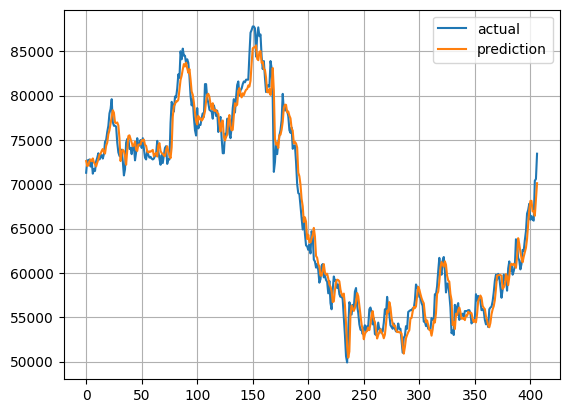

In [17]:
# 시각화 - 삼성전자 주가 예측, 원래 가격
plt.plot(y_test_inverse, label='actual')
plt.plot(pred_inverse, label='prediction')
plt.grid()
plt.legend()

plt.show()

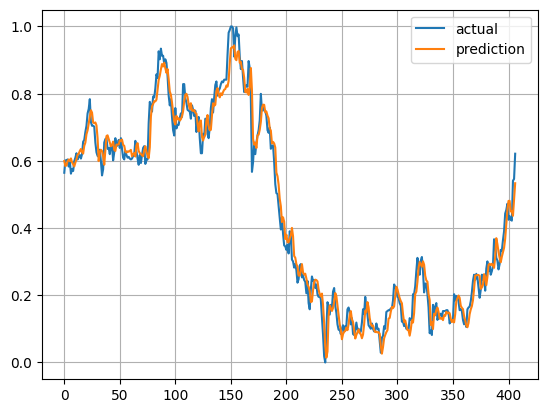

In [18]:
# 시각화 - 삼성전자 주가 예측, 너파이 가격
plt.plot(y_test_numpy, label='actual')
plt.plot(test_pred_numpy, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [19]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_gru_stock.ckpt')